In [2]:
import torch 
import torch.nn as nn
import torch.nn.functional as f
from torch.utils.data import Dataset,DataLoader
from torch.optim.lr_scheduler import StepLR,ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import json
from scipy import signal
import os
from collections import Counter
import random
# os.environ["MP_DUPLICATE_LIB_OK"] = "True"

## Call model

In [3]:
class cnn_lstm(nn.Module):
    def __init__(self,chunk =10,sigmoid_state=True,len_input = 16,outputa = 50):
        super().__init__()
        if chunk == 10:
            sep = 384//4 # due to 2 maxPool1d Kernel_size = 2
        if chunk == 50:
            sep = 1280
        if chunk == 100:
            sep = 3200//4
        if chunk == 200:
            sep = 6400//4
        self.model = nn.Sequential(nn.Conv1d(len_input,256,4,stride=1),
                                   nn.MaxPool1d(kernel_size=2),
                                   nn.ReLU(),
                                   nn.Conv1d(256,512,4,stride=1),
                                #    nn.MaxPool1d(kernel_size=2),
                                   nn.ReLU(),
                                   nn.Flatten(),
                                   nn.LSTM(sep *2 * 4,256)
                                   
                                    )
        self.dropout = nn.Dropout(p=0.3)
        self.lstm1 = nn.LSTM(256,128)
        self.lstm2 = nn.LSTM(100,100)
        self.biLSTM = nn.LSTM(100,100,bidirectional=True)
        # self.linear1 = nn.Linear(200,100)
        self.linear2 = nn.Linear(128,outputa)
        self.sigmoid  = nn.Sigmoid()
        self.softmax  = nn.Softmax(dim=1)
        self.sigmoid_state = sigmoid_state
    def forward(self,x):
        output, (hn,cn) = self.model(x)
        # output = self.model(x)
        
        output = self.dropout(output)
        output, (hn,cn) = self.lstm1(output)
        output = self.dropout(output)

        
        # output, (hn,cn) = self.lstm2(output)
        # output, (hn,cn) = self.biLSTM(output)
        # output = self.dropout(output)
        # y = self.linear1(output)
        y_final = self.linear2(output)
        
        if self.sigmoid_state:
            y_final = self.sigmoid(y_final)
        else:
            y_final = self.softmax(y_final)

        return y_final
    
    
class cnn_mlp(nn.Module): #slow af
    def __init__(self,chunk =10,sigmoid_state=True,len_input = 16,outputa = 50):
        super().__init__()
        if chunk == 10:
            sep = 384//4 # due to 2 maxPool1d Kernel_size = 2
        if chunk == 50:
            sep = 1280
        if chunk == 100:
            sep = 3200//4
        if chunk == 200:
            sep = 6400//4
        self.model = nn.Sequential(nn.Conv2d(1,64,4),
                                   nn.Conv2d(64,128,4),
                                #    nn.Conv2d(512,1024,4),
                                   nn.Flatten(),
                                   nn.LazyLinear(512),
                                   nn.LazyLinear(256),
                                   nn.LazyLinear(64),
                                   nn.LazyLinear(outputa),
                                   nn.Sigmoid()
                                   
                                    )
    def forward(self,x):
        output= self.model(x)
        return output
    
    
class CustomDataset(Dataset):
    def __init__(self,
                 csv_path,
                 batch=16,
                 chunk = 100,
                 vocab_path = "../Sign_Language_Detection/label.json",
                table:bool = False,
                dataframe=None):
        
        
        with open(vocab_path,"r") as f:
            compare = json.load(f)
        self.vocab = len(compare)
        
        if not table:
            self._data_csv = pd.read_csv(csv_path)
        else:
            self._data_csv = dataframe
        
        
        self._data_csv = self._data_csv[~(self._data_csv.Label.isin([ "cooldown","error_redo","break_time",]))]
        self._data_csv["Label"] = self._data_csv["Label"].apply(lambda x:compare[x])
        self.train_data = self.convert_data_csv_train(self._data_csv,compare,segment=chunk,range_data=25)
        # print(len(self.train_data))
        
        print(self.train_data.size())
        fity = []
        normal =[]
        for i in self.train_data:
            # print(i[:,-1][0])
            if int(i[:,-1][-1]) == 0:
                fity.append(i)
            else:
                normal.append(i)
        # print(len(fity))
        # print(len(normal))
        fity = random.sample(fity,int(len(fity) * 0.5))
        normal.extend(fity)
        self.train_data = normal
        self.nums  = len(self.train_data)
        self.answer_transform = []
    
        self.train_data = torch.tensor([i.tolist() for i in self.train_data])
        
        
        for i in range(0,len(self.train_data)):
            # print(self.train_data)
            
            
            dummy = torch.zeros(self.vocab)
            ct = Counter(self.train_data[i][:,-1].tolist()).most_common()
            if len(ct) == 2 and ct[0][0] ==0:
                idx,count = Counter(self.train_data[i][:,-1].tolist()).most_common()[1]
            else:
                idx,count = Counter(self.train_data[i][:,-1].tolist()).most_common()[0]
            
            dummy[int(idx)] = 1
            self.answer_transform.append(dummy)
        
        self.train_data = self.train_data[:,:,:-1]
        self.nums,self.segment,self.input = self.train_data.size()
        
        
    def __getitem__(self, index):
        
        inputs = self.train_data[index]
        answer = self.answer_transform[index]
        
        if torch.cuda.is_available():
            return inputs.to(torch.float32).movedim(1,0).to("cuda"),answer.to("cuda")
        else:
            return inputs.to(torch.float32).movedim(1,0),answer
        
        
    def __len__(self):
        return self.nums
    
    def len_answer(self):
        return self.vocab
    
    def data_info(self):
        return self.nums,self.segment,self.input,self.train_data
    
    
    def complementary_filter(self,gyro,gyro2,gyro3, angle_meas, dt, alpha=0.02):

            angle_est = np.zeros_like(gyro)
            angle_est[0] = angle_meas[0]  # initialize
            for i in range(1, len(gyro)):
                gyro_all = math.sqrt(gyro[i]**2 +gyro2[i]**2 + gyro3[i]**2) * 180/math.pi
                gyro_pred = angle_est[i-1] +  gyro_all * dt
                angle_est[i] = alpha * gyro_pred + (1 - alpha) * angle_meas[i]
            return angle_est

    def data_processing(self,train,x,x2,x3,y,alpha):
            gyro = train[x].to_list() 
            gyro2 = train[x2].to_list()
            gyro3 = train[x3].to_list()
            angle_meas = train[y].to_list()

            angle_est = self.complementary_filter(gyro,gyro2,gyro3,angle_meas,alpha)
            return angle_est
        
        
    def kalman_cal(self,data,col):

        sensor_data = data[col].values.tolist()

        kf = KalmanFilter()

        filtered_data = []
        for measurement in sensor_data:
            estimate = kf.update(measurement)
            filtered_data.append(estimate)

        return filtered_data
    
    def convert_data_csv_train(self,data,compare,segment=50,range_data = 0):

        datta = []
        previous = None
        samples = []
        abc= []
        print("extrac Value")
        # for i in tqdm(data.values,total = len(data)):
            
        #     if i[-1] != previous:
        #         if previous == None:
        #             samples.append(i)
        #             previous = i[-1]
        #         else:
        #             datta.append(samples)
        #             samples = []
        #             previous = i[-1]
        #     elif i[-1] == previous:
        #         samples.append(i)
        
        data['group_id'] = (data['Label'] != data['Label'].shift()).cumsum()
        grouped_dfs = [g.drop(columns='group_id').values for _, g in data.groupby('group_id')]
        
        
        
        print("len(data): ",len(grouped_dfs))
        print("filter Value")
        all_data = []
        for i in tqdm(grouped_dfs,total = len(grouped_dfs)):
            if len(i) > range_data:
                all_data.append(i)


        print("pad&mean Value")

        real = []
        for i in tqdm(all_data,total = len(all_data)):
            segment = segment
            if len(i) < segment:
                tensor_df = (torch.tensor(i))
                n,b = tensor_df.size()
                padded_tensor = torch.nn.functional.pad(tensor_df, pad=(0, 0, segment-n, 0), mode='constant', value=0)
                # print(padded_tensor.size())
                real.append(padded_tensor.tolist())
            else:
                step = int(np.ceil(len(i)//segment))
                temp = []
                for k in range(segment):
                    temp.append(torch.mean(torch.tensor(i[k*step:(k+1)*step]),dim=0).tolist())
                real.append(temp)

        train_data = torch.tensor(real)
        return train_data
    
        
class KalmanFilter:
    def __init__(self, process_variance=1e-4, measurement_variance=0.01, initial_estimate=0.0, initial_error=1.0):
        self.Q = process_variance     # ความไม่แน่นอนของกระบวนการ (process noise)
        self.R = measurement_variance # ความไม่แน่นอนของการวัด (sensor noise)
        self.x = initial_estimate     # ค่าประมาณเริ่มต้น (initial estimate)
        self.P = initial_error        # ความไม่แน่นอนของค่าประมาณเริ่มต้น (initial error)
    
    def update(self, measurement):
        # Predict step
        self.P += self.Q

        # Kalman Gain
        K = self.P / (self.P + self.R)

        # Update estimate with measurement
        self.x += K * (measurement - self.x)

        # Update error
        self.P *= (1 - K)

        return self.x

    
        
        
    
    
# cnn = cnn_lstm()
    

In [15]:
import json

with open("label.json",'w') as f:
    json.dump(dict,f,indent=1,ensure_ascii=False)

In [24]:
with open('label.json','r') as f:
    ct = json.load(f)

base_df['Label'] = base_df['Label'].apply(lambda x:ct[x])
base_df['group_id'] = (base_df['Label'] != base_df['Label'].shift()).cumsum()

# Create a list of grouped DataFrames
grouped_dfs = [g.drop(columns='group_id') for _, g in base_df.groupby('group_id')]

## EDA

In [ ]:
data = pd.read_csv("collect_data/20250618_141745_test_sus_1_sensor.csv")

data_normal = data[~(data["Label"] == "nothing")]
notthin = data[(data["Label"] == "nothing")].sample(n=5000)
data = pd.concat([data_normal,notthin]).reset_index(drop=True)
data = data[~data.Label.isin(["error_redo","break_time","cooldown"])].reset_index(drop=True)
# data = data.sample(n=len(data),random_state=42).reset_index(drop=True)
# column = [ 
#     "motion_detected",
#     "roll_deg", 
#     "pitch_deg", 
#     "yaw_deg",
#     "filtered_accel_x_(m/s²)", 
#     "filtered_accel_y_(m/s²)", 
#     "filtered_accel_z_(m/s²)",
#     "filtered_gyro_x_(deg/s)",
#     "filtered_gyro_y_(deg/s)",
#     "filtered_gyro_z_(deg/s)",
#     "accel_magnitude", 
#     "gyro_magnitude",
#     "adc0", 
#     "adc1", 
#     "adc2", 
#     "adc3", 
#     "adc4"
#     "Label"]
train = data.drop(columns = ["Label","timestamp_ms"])
test = data[["Label"]]["Label"]

import json


In [101]:
with open("../Sign_Language_Detection/label.json","r") as f:
    compare = json.load(f)
data = pd.read_csv(r"F:\Hybridmodel-project\Sign_Language_Detection\collect_data\20250624_101902_ชาตชาย24062025_sensor.csv")
data["Label"] = data["Label"].apply(lambda x:compare[x])


In [32]:
def paa(df, segments=50):
    n = len(df)
    frame_size = n // segments
    reduced = []

    for i in range(segments):
        start = i * frame_size
        end = (i + 1) * frame_size if i < segments - 1 else n
        reduced.append(df.iloc[start:end].mean())

    return pd.DataFrame(reduced)


In [ ]:
import os
from scipy.signal import medfilt
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
# name = ['gyro_y', 'gyro_z', 'accel_x', 'accel_y', 'accel_z', 'angle_x',
#        'angle_y', 'angle_z', 'adc0', 'adc1', 'adc2', 'adc3', 'adc4',]
# fig ,ax = plt.subplots(5,4,figsize=(25, 25))

# data["Label"] = data["Label"].apply(lambda x:compare[x])
data = new_df

# for i in range(5):
#     # data[f"adc{i}_fil"] = data_processing(data,"filtered_gyro_x_(deg/s)","filtered_gyro_y_(deg/s)","filtered_gyro_z_(deg/s)",f"adc{i}",0.02)
#     data[f"adc{i}_fil"] = kalman_cal(data,f"adc{i}")
    
data[f"gyrox"] = kalman_cal(data,"gyro_x")  
data[f"gyroy"] = kalman_cal(data,"gyro_y")  
data[f"gyroz"] = kalman_cal(data,"gyro_z")  
    

# inputs = data[name].values
data
n = 0
swgment = 5000
checker = []
for k in range(1,3):
    # trains = data[data["Label"] == k].reset_index(drop=True)
    trains = data
    # trains2 = data[data["Label"] == k+1].reset_index(drop=True)
    inputs = trains.values
    # imputs2 = trains2.values
    for i in range(len(trains.columns)):
        # if "gyro" in data.columns[i]:

        x = torch.arange(len(torch.tensor(inputs[:swgment])))
        plt.figure(figsize=(25,10))
        plt.plot(x,(torch.tensor(inputs[:swgment])[:,i]))
        # plt.plot(x,medfilt(torch.tensor(inputs[:swgment])[:,i],kernel_size=5))
        
        
        # plt.plot(x,(torch.tensor(imputs2[:swgment])[:,i]))
        # # plt.plot(x,medfilt(torch.tensor(imputs2[:swgment])[:,i],kernel_size=9))
        plt.title(f"code {k} compare to {k+1} using {data.columns[i]}")
        # checker.append(torch.tensor(inputs[:swgment])[:,i])
        # ax[n,i%4].plot(x,torch.tensor(inputs[:])[:,i])
        # ax[n,i%4].set_title(name[i])


plt.show()

## Train

In [383]:
def convert_data_csv_train(data,compare,segment=50,range_data = 0):

        datta = []
        previous = None
        samples = []
        abc= []
        print("extrac Value")
        for i in tqdm(data.values,total = len(data)):
            
            if i[-1] != previous:
                if previous == None:
                    samples.append(i)
                    previous = i[-1]
                else:
                    datta.append(samples)
                    samples = []
                    previous = i[-1]
            elif i[-1] == previous:
                samples.append(i)
        print("len(data): ",len(datta))
        print("filter Value")
        all_data = []
        for i in tqdm(datta,total = len(datta)):
            if len(i) > range_data:
                all_data.append(i)


        print("pad&mean Value")

        real = []
        for i in tqdm(all_data,total = len(all_data)):
            segment = segment
            if len(i) < segment:
                tensor_df = (torch.tensor(i))
                n,b = tensor_df.size()
                padded_tensor = torch.nn.functional.pad(tensor_df, pad=(0, 0, segment-n, 0), mode='constant', value=0)
                # print(padded_tensor.size())
                real.append(padded_tensor.tolist())
            else:
                step = int(np.ceil(len(i)//segment))
                temp = []
                for k in range(segment):
                    temp.append(torch.mean(torch.tensor(i[k*step:(k+1)*step]),dim=0).tolist())
                real.append(temp)

        train_data = torch.tensor(real)
        return train_data,all_data

In [ ]:
with open("../Sign_Language_Detection/label.json","r") as f:
    compare = json.load(f)
df = pd.read_csv(r"collect_data/20250624_101902_ชาตชาย24062025_sensor.csv")
df["Label"] = df["Label"].apply(lambda x:compare[x])

train,_all = convert_data_csv_train(df,compare)

In [ ]:
# # train.size()

# with open("rollback.json",'r') as f:
#     ct = json.load(f)
    
    
# print(len(data_answer))
# label_list = [int(torch.argmax(i)) for i in data_answer] 
# nv = Counter(label_list)
# print(nv.most_common())



# not_eng = []
# for i,v in nv.most_common():
#     print(f"{ct[str(i)]} : {v} ")

In [ ]:
# train_dataset = CustomDataset("collect_data/20250624_101902_ชาตชาย24062025_sensor.csv",vocab_path="../Sign_Language_Detection/label.json",chunk=50,table=True,dataframe=base_df)
# data_answer = []
# for inputs,answer in tqdm(train_dataset):
      
#       # try:
#           # print(torch.tensor(inputs[i:i+chunk]).size())
#       data_answer.append(answer)

In [30]:
import glob
import os

base_df = pd.DataFrame()
for i in glob.glob(r"./collect_data/new_data/*"):
    df = pd.read_csv(rf"{i}")
    base_df = pd.concat([base_df,df])
print(len(base_df))


413849


In [4]:
epoch = 1
lr = 2e-5
chunk = 50
e = 0
best_loss = 0
path_save = "../Sign_Language_Detection/model/Version1"
num_still = 0
sigoid_state = True
batch_size = 1
train_dataset = CustomDataset("collect_data/20250624_101902_ชาตชาย24062025_sensor.csv",vocab_path="../Sign_Language_Detection/label.json",chunk=50,table=True,dataframe=base_df)

len_output = train_dataset.len_answer()
len_input = train_dataset.data_info()[-2]
train_dataset = DataLoader(train_dataset,batch_size=batch_size)

if torch.cuda.is_available():
  cnn = cnn_lstm(chunk,sigmoid_state=sigoid_state,len_input=len_input,outputa=len_output).to("cuda")
else:
  cnn = cnn_lstm(chunk,sigmoid_state=sigoid_state,len_input=len_input,outputa=len_output)



# if torch.cuda.is_available():
#   cnn = cnn_mlp(chunk,sigmoid_state=sigoid_state,len_input=len_input,outputa=len_output).to("cuda")
#   print("use cuda")
# else:
#   cnn = cnn_mlp(chunk,sigmoid_state=sigoid_state,len_input=len_input,outputa=len_output)



optimizer = torch.optim.AdamW(cnn.parameters(),lr=lr,weight_decay=0.0001)
criterion = nn.MSELoss()
# criterion = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, 'min',patience =3  ,min_lr = 5e-6,factor=0.5)
print(f" data train = {int(len(train_dataset)*batch_size)} with {len_input} feature")



n = 0
for param in cnn.parameters():
  param.requires_grad=True
cnn.train()

for k in range(epoch):
    loss_total = 0
    data_answer = []
    for inputs,answer in tqdm(train_dataset):
      
      # try:
          # print(torch.tensor(inputs[i:i+chunk]).size())
      data_answer.append(answer)
      # print(inputs.size())
      output = cnn(inputs)
      optimizer.zero_grad()
      if torch.argmax(answer).item() == 0:
        loss = criterion(output,answer)*0.08
      else:
        loss = criterion(output,answer)
      
      
      # print(f"answer = {output[0]}")
      # print(f"output = {answer[0]}")
      # print(loss)
      # break
      
      loss.backward()

      optimizer.step()
      # if k == 15:
      #   print(f"Label = {torch.argmax(answer)} model answer = {torch.argmax(output[0])}")

      loss_total += loss
      n+=1
      # if n == 5:
      #   break
      # except:
      #   print("face error")
        
    if best_loss == 0 or best_loss > loss_total/len(train_dataset):
      best_loss = loss_total/len(train_dataset)
      state_dict = cnn.state_dict()
      e = k
      num_still = 0
    else:
      num_still +=1
      
    scheduler.step(loss_total/len(train_dataset))
    num_still = 0
    if num_still >= 3:
      print("step up to learning = ",scheduler.get_last_lr())
      break
      
    
    print(f"epoch number {k} loss = {loss_total/len(train_dataset)} with lr = {scheduler.get_last_lr()}")
    # break
print(f"best loss at epoch = {e+1} with {best_loss}")
torch.save(state_dict,f"{path_save}/model_epoch_{e}")



NameError: name 'base_df' is not defined

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [3]:
import json
with open(r"./label.json",'r') as f:
    ct = json.load(f)

In [4]:
datac = {}
for i,v in ct.items():
    datac[v] = i

In [6]:
with open("rollback.json",'w') as f:
    json.dump(datac,f,indent=1,ensure_ascii=False)

In [63]:

test_df = pd.DataFrame()
for i in glob.glob(r"./collect_data/new_data/*test_*.csv"):
    df = pd.read_csv(rf"{i}")
    test_df = pd.concat([test_df,df])
print(len(test_df))

1636


In [ ]:
# test_df = pd.read_csv(rf"F:\Hybridmodel-project\Sign_Language_Detection\collect_data\20250715_111750_DATA_INDICATOR_sensor.csv")

In [37]:
test_df = base_df.iloc[:100000]

In [38]:
import glob
import os

# test_df = pd.DataFrame()
# for i in glob.glob(r"./collect_data/new_data/*test_*.csv"):
#     df = pd.read_csv(rf"{i}")
#     test_df = pd.concat([test_df,df])
# print(len(test_df))





test_dataset = CustomDataset("collect_data/20250624_131408_พชชาภา24062025_sensor.csv",vocab_path="../Sign_Language_Detection/label.json",chunk=chunk,table=True,dataframe=test_df)
test_dataset = DataLoader(test_dataset,batch_size=1)

y_pred = []
y_true = []
# notthing_c = 0
# action = []
# start = True
with torch.no_grad():
    # for i in tqdm(range(0,int(len(inputs)),chunk)):
    #     try:
    #         # print(torch.tensor(inputs[i:i+chunk]).size())
    #         output = cnn(torch.tensor(inputs[i:i+chunk]).movedim(1,0).unsqueeze(0).to("cuda"))
    #         y_pred.append(torch.argmax(output).item())
    #         y_true.append(torch.argmax(answer[int(i/chunk)]).item())
            
    #         with torch.no_grad():
    for inputs,answer in tqdm(test_dataset):
        
        output = cnn(inputs)
        # loss = criterion(output[0],answer[0])
        # if torch.argmax(answer,dim=1)[0].item() != 0:
            # print((torch.argmax(answer,dim=1)).tolist())
        y_pred += (torch.argmax(output,dim=1)).tolist()
        y_true += (torch.argmax(answer,dim=1)).tolist()
        
        # if torch.argmax(output).item() != 11:
        #     action.append(torch.argmax(output).item())
        #     start = False
        # else:
        #     notthing_c+=1
        
        # if notthing_c >= 10 and not start :
        #     print(action[-1])
            
            

C:\Users\wayupuk sommuang\AppData\Local\Temp\ipykernel_3252\546437141.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._data_csv["Label"] = self._data_csv["Label"].apply(lambda x:compare[x])
C:\Users\wayupuk sommuang\AppData\Local\Temp\ipykernel_3252\546437141.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['group_id'] = (data['Label'] != data['Label'].shift()).cumsum()


extrac Value
len(data):  1384
filter Value


  0%|          | 0/1384 [00:00<?, ?it/s]

pad&mean Value


  0%|          | 0/713 [00:00<?, ?it/s]

torch.Size([713, 50, 30])


  0%|          | 0/702 [00:00<?, ?it/s]

In [39]:
from sklearn.metrics import f1_score,recall_score,accuracy_score
f1_scores = f1_score(y_true, y_pred, average="micro")
print("f1 score    ",f1_scores)
recall_scores = recall_score(y_true, y_pred, average="micro")
print("recal score ",recall_scores)
acc = accuracy_score(y_true, y_pred)
print("acc score   ",acc)

f1 score     0.004273504273504274
recal score  0.004273504273504274
acc score    0.004273504273504274


In [40]:
for i,v in zip(y_true,y_pred):
    if i==v:
        print(i)

39
39
57


In [ ]:
#PFI test

for k in range(17):
    y_pred = []
    y_true = []
    with torch.no_grad():
        for i in tqdm(range(0,int(len(inputs)),chunk)):
            try:
                # print(torch.tensor(inputs[i:i+chunk]).size())
                data = torch.tensor(inputs[i:i+chunk])
                data[:,k] = 0
                output = cnn(data.movedim(1,0).unsqueeze(0).to("cuda"))
                y_pred.append(torch.argmax(output).item())
                y_true.append(torch.argmax(answer[int(i/chunk)]).item())
     
                
                # if torch.argmax(output).item() != 11:
                #     action.append(torch.argmax(output).item())
                #     start = False
                # else:
                #     notthing_c+=1
                
                # if notthing_c >= 10 and not start :
                #     print(action[-1])
            except:
                print("hello")
    acc = accuracy_score(y_true, y_pred)
    print(f"acc score  {acc}  on {column[k]}")  

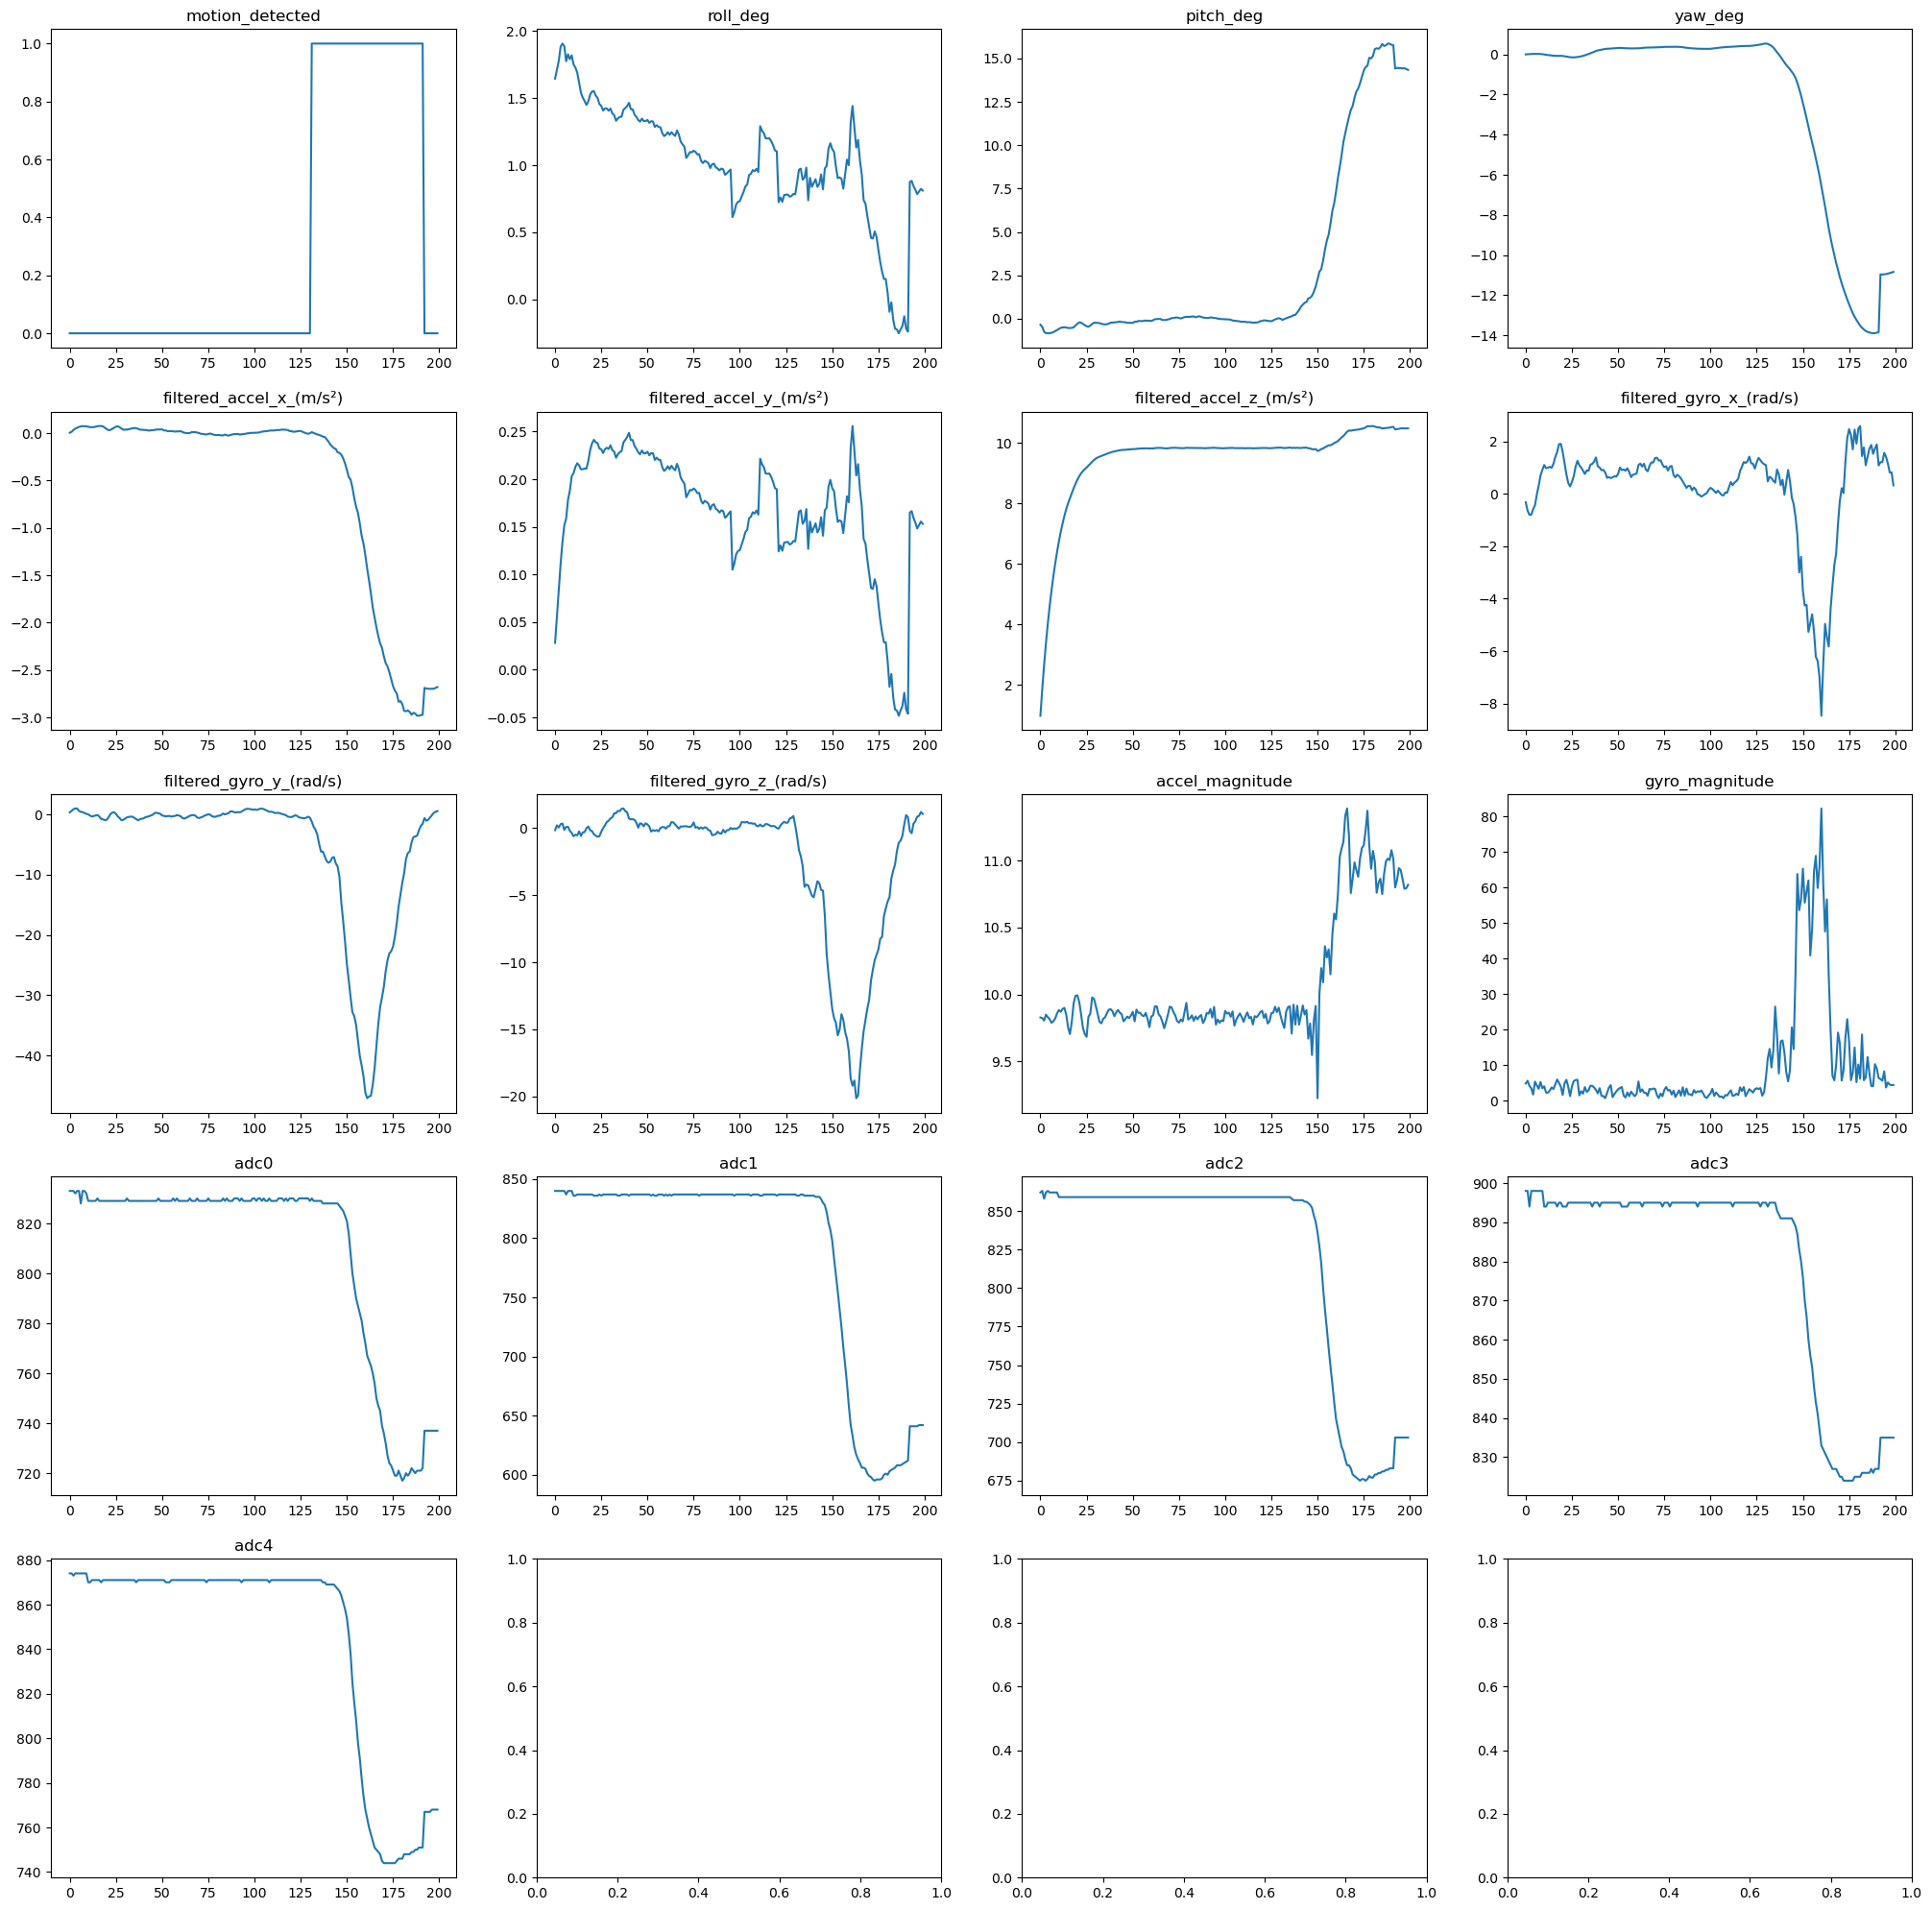

# model2

## text embedding way

In [111]:
class decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(50,256)
        self.l2 = nn.Linear(256,50)
    def forward(self,x):
        x = self.l1(x)
        x = self.l2(x)
        return x


class cnn_lstm_multi(nn.Module):
    def __init__(self,chunk =10):
        super().__init__()
        if chunk == 10:
            sep = 384
        if chunk == 50:
            sep = 1664
        if chunk == 100:
            sep = 3200
        if chunk == 200:
            sep = 6400
        self.model = nn.Sequential(nn.Conv1d(17,256,2,stride=2),
                                   nn.ReLU(),
                                   nn.Conv1d(256,128,1,stride=2),
                                   nn.ReLU(),
                                   nn.MaxPool1d(kernel_size=1),
                                   nn.Flatten(),
                                    nn.LSTM(sep,100)
                                   
                                    )
        self.dropout = nn.Dropout(p=0.2)
        self.lstm1 = nn.LSTM(100,100)
        self.b1 = nn.BatchNorm1d(100)
        self.lstm2 = nn.LSTM(100,100)
        self.b2 = nn.BatchNorm1d(100)
        self.biLSTM = nn.LSTM(100,100,bidirectional=True)
        self.linear1 = nn.Linear(200,100)
        self.linear2 = nn.Linear(100,50)
        # self.leru = nn.Softmax(dim=1)
        self.leru = nn.Sigmoid()
        self.emb = nn.Embedding(100,50)
        self.decoder = decoder()
        
    def forward(self,x):
        output, (hn,cn) = self.model(x)
        # output = self.model(x)
        
        output = self.dropout(output)
        output, (hn,cn) = self.lstm1(output)
        # output = self.b1(output)
        output, (hn,cn) = self.lstm2(output)
        # output = self.b2(output)
        output, (hn,cn) = self.biLSTM(output)
        y = self.linear1(output)
        y_final = self.linear2(y)
        y_final = self.leru(y_final)

        return y_final
    
    def nums_to_word(self,x):
        word = self.decoder(x)
        
        return word
    
    def words_to_nums(self,x):
        word = self.emb(torch.tensor(compare[x],dtype=torch.long))
        
        return word
    
    
cnn = cnn_lstm_multi()
    

In [88]:
with open("../Sign_Language_Detection/turnback.json","r") as f:
    turnback = json.load(f)


In [122]:
turnback

{'0': 'ฉัน',
 '1': 'คุณ',
 '2': 'เขา',
 '3': 'เรา',
 '4': 'กิน',
 '5': 'ดื ่ม',
 '6': 'ไป',
 '7': 'มา',
 '8': 'ป่วย',
 '9': 'ชอบ',
 '10': 'ต้องการ',
 '11': 'มี',
 '12': 'ทำ',
 '13': 'พูด',
 '14': 'อ่าน',
 '15': 'เขียน',
 '16': 'นอน',
 '17': 'เล่น',
 '18': 'เดิน',
 '19': 'วิ่ง',
 '20': 'ดี',
 '21': 'ร้าย',
 '22': 'ใหญ่',
 '23': 'เล็ก',
 '24': 'ร้อน',
 '25': 'หนาว',
 '26': 'วันนี้',
 '27': 'พรุ่งนี้',
 '28': 'เมื่อวาน',
 '29': 'บ้าน',
 '30': 'โรงเรียน',
 '31': 'เพื่อน',
 '32': 'น้ำ',
 '33': 'อาหาร',
 '34': 'กาแฟ',
 '35': 'หนังสือ',
 '36': 'โทรศัพท์',
 '37': 'รถ',
 '38': 'เวลา',
 '39': 'ตอนนี้',
 '40': 'ทีหลัง',
 '41': 'ที่นี่',
 '42': 'ที่นั่น',
 '43': 'คำถาม',
 '44': 'อันตราย',
 '45': 'ช่วย',
 '46': 'รอ',
 '47': 'เข้าใจ',
 '48': 'เรียน',
 '49': 'ทำงาน',
 '50': 'normal',
 '51': 'กำหมัด'}

In [ ]:

epoch = 20
lr = 0.002
chunk = 50
inputs = train.values.tolist()
answer = test

cnn = cnn_lstm_multi(chunk)
optimizer = torch.optim.AdamW(cnn.parameters())
cnn.emb.requires_grad_ = False
# criterion = nn.MSELoss()
criterion = nn.CrossEntropyLoss()
for param in cnn.parameters():
  param.requires_grad=True
cnn.train()
for i in range(epoch):
    # output = cnn(torch.tensor(inputs[i],dtype=torch.float64).unsqueeze(0))
    for i in range(0,int(len(inputs)),chunk):
        # print(torch.tensor(inputs[i:i+chunk]).size())
        try:
          output = cnn(torch.tensor(inputs[i:i+chunk]).movedim(1,0).unsqueeze(0))
          optimizer.zero_grad()
          # print(output)
          loss = criterion(output[0],cnn.words_to_nums(answer[i//10]))
          loss.backward()
          optimizer.step()
        except:
          print("")
    print(f"loss = {loss}")

In [88]:
test_dataset = CustomDataset("collect_data/test_v2_sensor.csv",vocab_path="../Sign_Language_Detection/onetoten.json",chunk=chunk)
test_dataset = DataLoader(test_dataset,batch_size=1)

y_pred = []
y_true = []
# ans = []
# for i in compare:
#     ans.append(cnn.words_to_nums(i))
cnn.to("cuda")
with torch.no_grad():

    for inputs,answer in tqdm(test_dataset):
        
        # try:
        output = cnn(inputs)
        
        # ,cnn.words_to_nums(answer[i//10])
        # y_pred += (torch.argmax(output,dim=1)).tolist()
        a = []
        for i in ans:
            a.append(sum((output[0]-i.to("cuda"))**2))
        answers = torch.argmax(torch.tensor(a)).item()
        
        if torch.argmax(answer) != 11:
            y_pred.append(answers)
            
            
            y_true.append(torch.argmax(answer))
            
            
            
            
        # except:
        #     print("hello")

KeyError: "['gyro_x', 'gyro_y', 'gyro_z', 'accel_x', 'accel_y', 'accel_z', 'angle_x', 'angle_y', 'angle_z'] not in index"

In [ ]:
c = 5
ini = 9.815 
final = 11.22147729
for i in range(c):
    print(ini + (final - ini)/c *(i+1))
    
c = 5
ini = -9.806 
final = -9.80778718
for i in range(c):
    print(ini + (final - ini)/c *(i+1))
    
c = 5
ini = 4.293
final = 5.21621735
for i in range(c):
    print(ini + (final - ini)/c *(i+1))

10.096295458
10.377590915999999
10.658886374
10.940181831999999
11.22147729


In [102]:
import torch
import matplotlib.pyplot as plt

In [117]:
an = torch.rand([10,4])
print(an)

print(an[...,:2])

tensor([[0.3486, 0.0443, 0.7455, 0.6406],
        [0.6052, 0.9404, 0.9280, 0.7596],
        [0.0101, 0.9972, 0.2713, 0.4279],
        [0.5039, 0.6746, 0.1528, 0.2821],
        [0.5386, 0.8519, 0.9396, 0.4103],
        [0.9112, 0.7736, 0.5378, 0.8257],
        [0.2121, 0.8062, 0.4420, 0.7098],
        [0.1217, 0.5135, 0.2459, 0.2181],
        [0.6894, 0.7498, 0.9693, 0.7922],
        [0.5408, 0.5955, 0.4163, 0.8173]])
tensor([[0.3486, 0.0443],
        [0.6052, 0.9404],
        [0.0101, 0.9972],
        [0.5039, 0.6746],
        [0.5386, 0.8519],
        [0.9112, 0.7736],
        [0.2121, 0.8062],
        [0.1217, 0.5135],
        [0.6894, 0.7498],
        [0.5408, 0.5955]])
